In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import matplotlib
import warnings
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

## Load the data and prepare

Load from CSV, drop the `Unnamed: 0` column (likely an index that was saved when writing to csv), and calculate a column to represent if the subject got the quadrant classification correct

In [2]:
df = pd.read_csv('./data/raw/WittData.csv')
# df.drop(columns=['Unnamed: 0'], inplace=True)
df['is_correct'] = df['resp'] == df['corrQuad']
df.head()

,Unnamed: 0,currImg,subj,resp,corrQuad,distToMiddle,meanSD,howManyCorr,isColSame,isSizeSame,isPulseSame,is_correct
0,1,1,5,A,B,0.133365,17.982569,2,1,1,0,False
1,2,1,8,A,B,0.133365,17.982569,2,1,1,0,False
2,3,1,12,A,B,0.133365,17.982569,2,1,1,0,False
3,4,1,14,A,B,0.133365,17.982569,2,1,1,0,False
4,5,1,15,B,B,0.133365,17.982569,2,1,1,0,True


## Histograms

Make some histograms to help make sure there is nothing unexpected with categorical variables

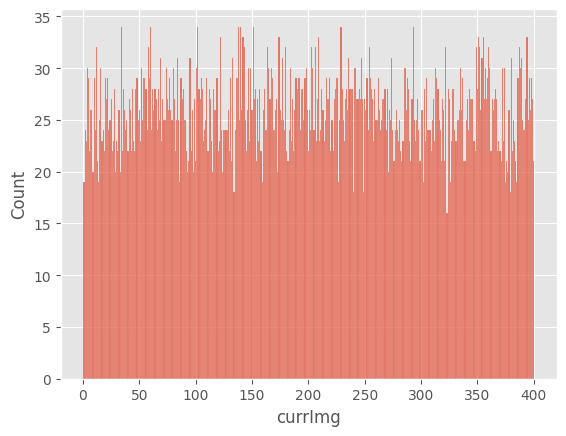

In [3]:
sns.histplot(df['currImg'], discrete=True)
plt.show()

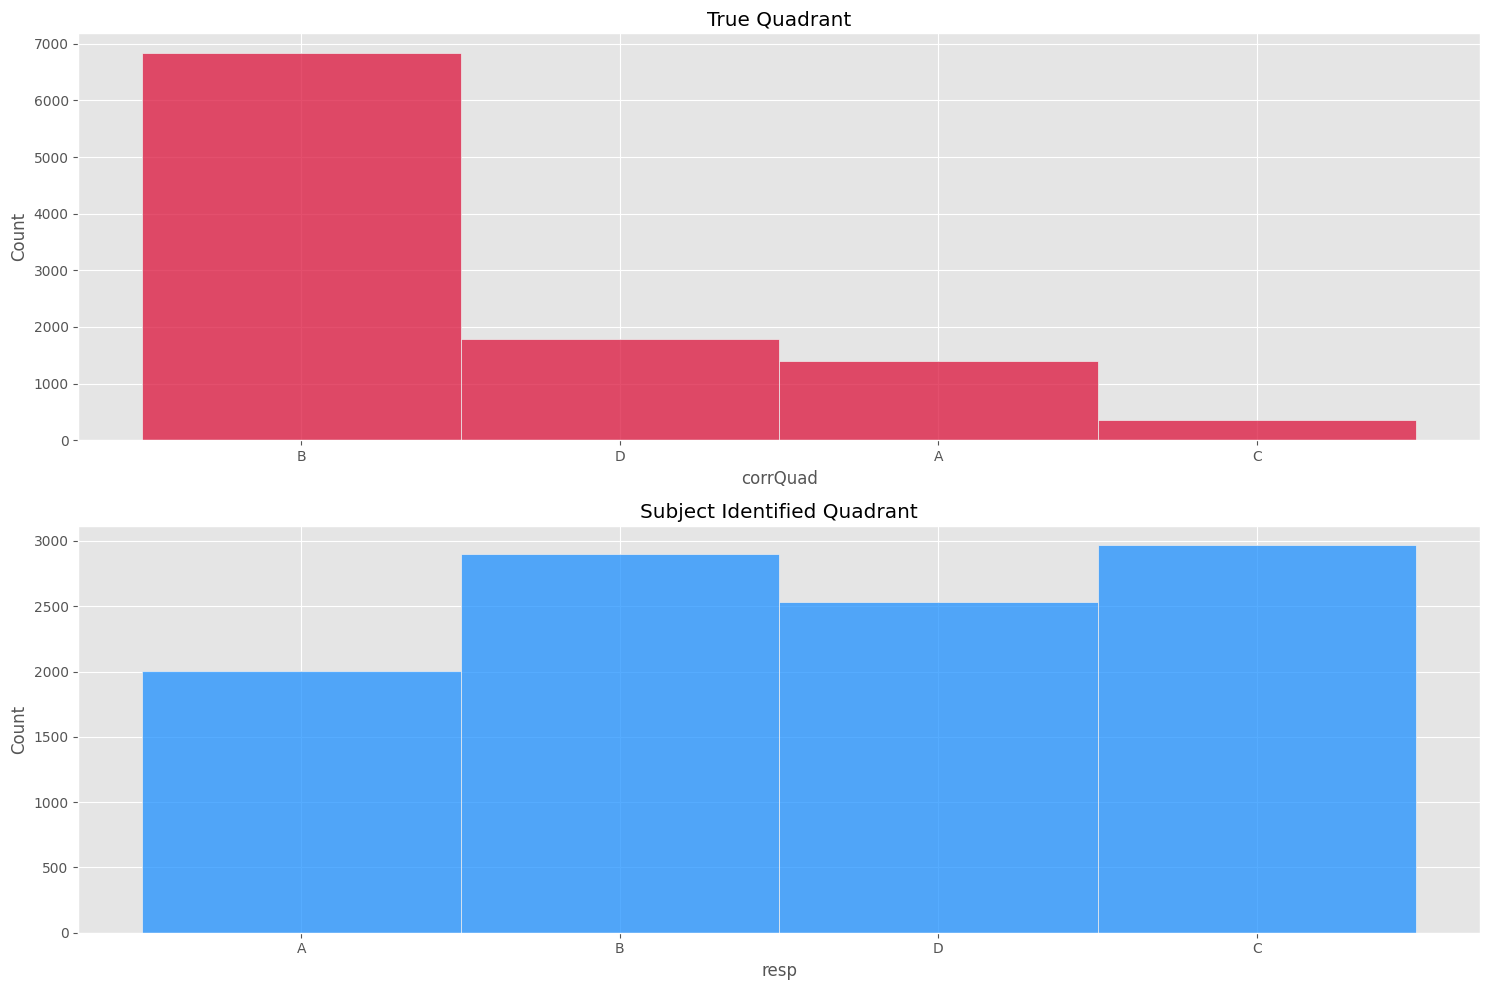

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10), tight_layout=True)
sns.histplot(df['corrQuad'], color='crimson', label='True Quadrant', ax=ax1)
sns.histplot(df['resp'], color='dodgerblue', label='Selected Quadrant', ax=ax2)
ax1.set_title('True Quadrant')
ax2.set_title('Subject Identified Quadrant')
plt.show()

**It looks like we have a big imbalance in the number of true quadrants, this seems odd...**

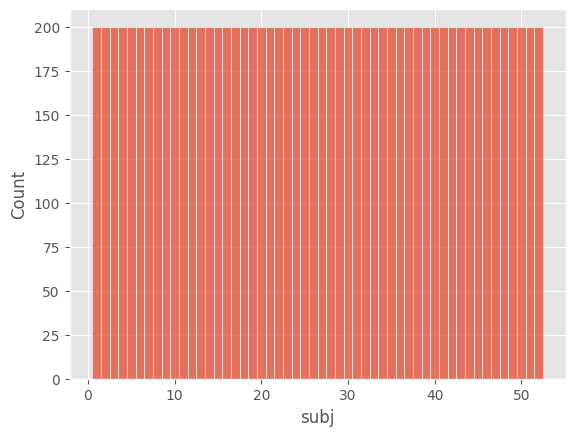

In [5]:
sns.histplot(data=df, x='subj', discrete=True)
plt.show()

## Take a look at the dots data
Take a look at the raw dots data to see if there is something funky going on with the quadrands

In [6]:
dots = pd.read_csv('./data/raw/Witt_Dots.csv')
dots[['x', 'y']].describe()

,x,y
count,36000.000000,36000.000000
mean,50.523991,50.256737
std,17.696734,18.152372
min,0.000000,0.000000
25%,38.443168,37.820033
50%,50.409438,50.260873
75%,62.391246,62.661689
max,100.000000,100.000000


### Calculate the mean of the dots, plot on a scatter plot and color by quadrant for QC

In [7]:
mean_dots = dots.groupby('currImg', as_index=False)[['x', 'y']].mean()

# Caclulate which quadrant dots are in, seems liek 50 should be the mid-point
conditions = [
    (mean_dots['x'] < 50) & (mean_dots['y'] > 50),
    (mean_dots['x'] > 50) & (mean_dots['y'] > 50),
    (mean_dots['x'] < 50) & (mean_dots['y'] < 50),
    (mean_dots['x'] > 50) & (mean_dots['y'] < 50)
]
values = ['A', 'B', 'C', 'D']
mean_dots['quadrant'] = np.select(conditions, values)


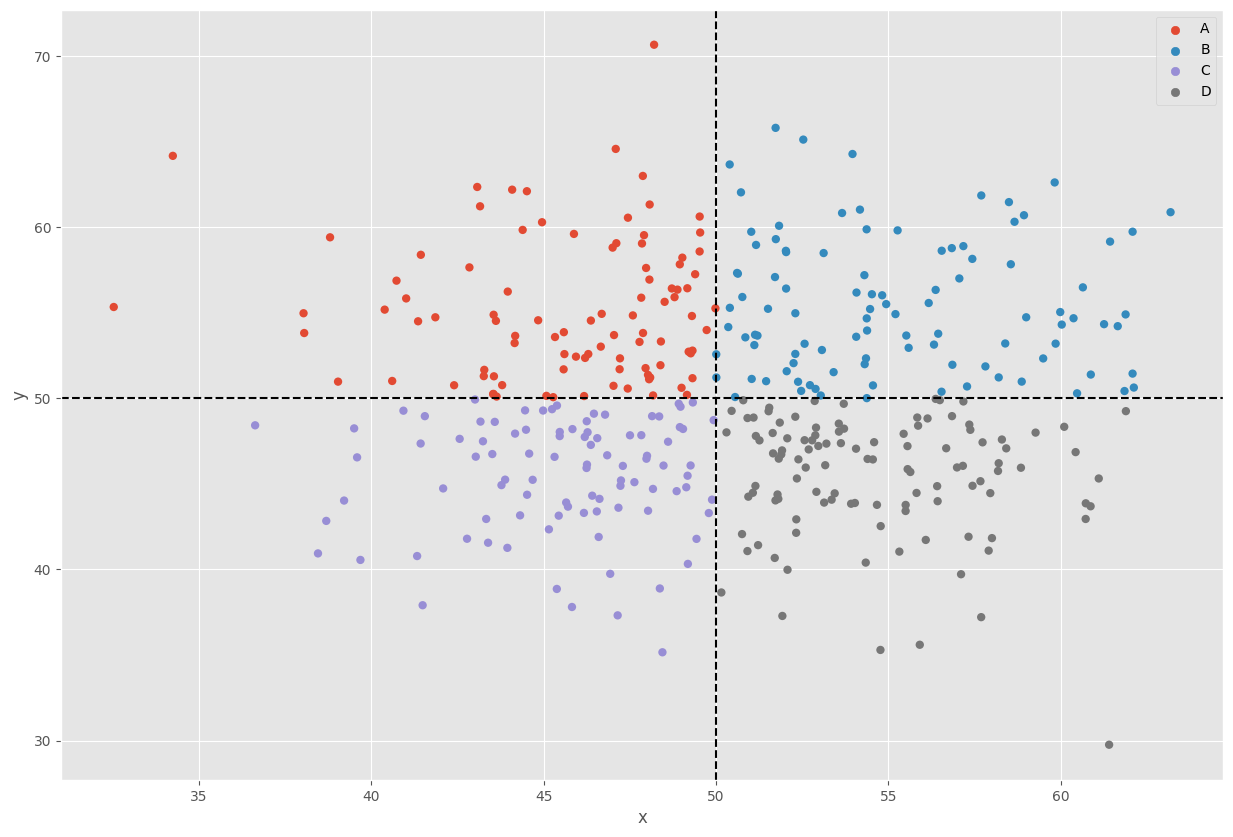

In [8]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=mean_dots.sort_values('quadrant'), x='x', y='y', hue='quadrant', linewidth=0)
plt.legend()
plt.axvline(50, color='black', linestyle='--')
plt.axhline(50, color='black', linestyle='--')
plt.show()

In [9]:
# Quick look at count in each quadrant, seems reasonable
mean_dots['quadrant'].value_counts()

quadrant
D    110
B    101
A     95
C     94
Name: count, dtype: int64

### Merge the calculated data back in and QC that

In [10]:
df_comb = pd.merge(df, mean_dots, on='currImg', how='left', validate='m:1')
df_comb['calc_is_correct'] = df_comb['quadrant'] == df_comb['resp'] # Calculate correctness based on our recalculated quadrants
df_comb.head()

,Unnamed: 0,currImg,subj,resp,corrQuad,distToMiddle,meanSD,howManyCorr,isColSame,isSizeSame,isPulseSame,is_correct,x,y,quadrant,calc_is_correct
0,1,1,5,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True
1,2,1,8,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True
2,3,1,12,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True
3,4,1,14,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True
4,5,1,15,B,B,0.133365,17.982569,2,1,1,0,True,48.882804,56.357519,A,False


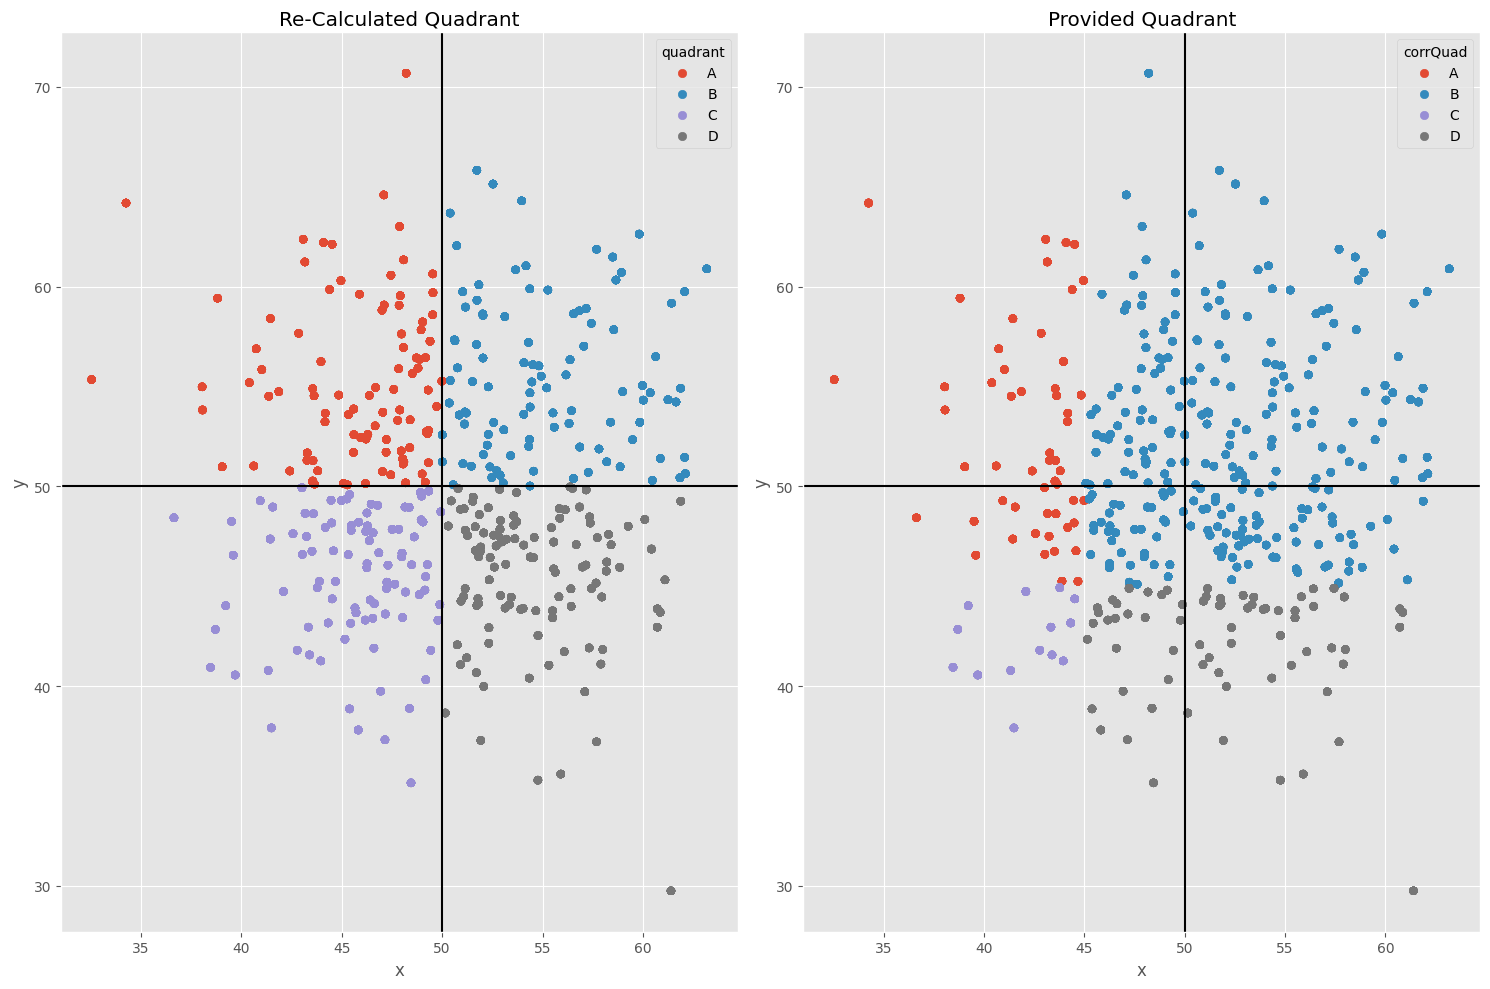

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10), tight_layout=True)
sns.scatterplot(data=df_comb.sort_values('quadrant'), x='x', y='y', hue='quadrant', linewidth=0, ax=ax1)
ax1.axhline(50, color='black')
ax1.axvline(50, color='black')
ax1.set_title('Re-Calculated Quadrant')
sns.scatterplot(data=df_comb.sort_values('corrQuad'), x='x', y='y', hue='corrQuad', linewidth=0, ax=ax2)
ax2.axhline(50, color='black')
ax2.axvline(50, color='black')
ax2.set_title('Provided Quadrant')
plt.show()

## Confusion Matrix

Plot confusion matrixes calculated with both the provided and recalculated quadrants

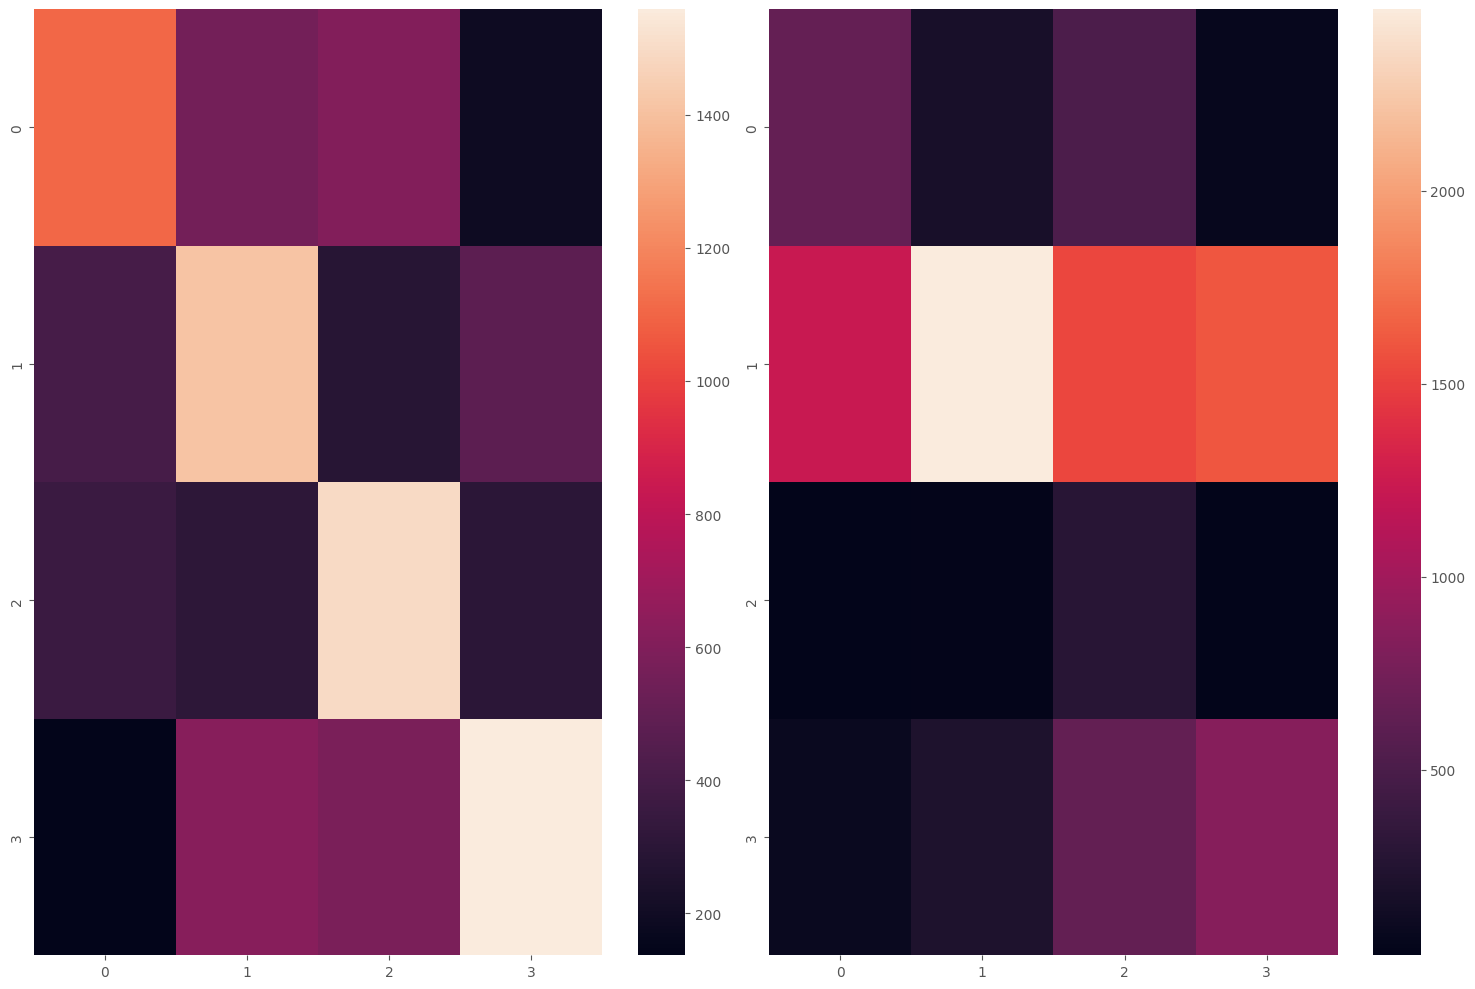

In [12]:
provided_conf_mat = confusion_matrix(df_comb['corrQuad'], df_comb['resp'])
recalc_conf_mat = confusion_matrix(df_comb['quadrant'], df_comb['resp'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10), tight_layout=True)
sns.heatmap(recalc_conf_mat, ax=ax1)
sns.heatmap(provided_conf_mat, ax=ax2)
plt.show()

**It seems that the participants also thought (50,50) was the midpoint as opposed to (45,45)**

In [13]:
prop_correct = df_comb.groupby('corrQuad')[['is_correct', 'calc_is_correct']].mean()
prop_correct

,is_correct,calc_is_correct
corrQuad,,
A,0.468616,0.569900
B,0.361152,0.493423
C,0.781768,0.781768
D,0.472687,0.620959


In [14]:
df_comb[['is_correct', 'calc_is_correct']].mean()

is_correct         0.409519
calc_is_correct    0.535769
dtype: float64

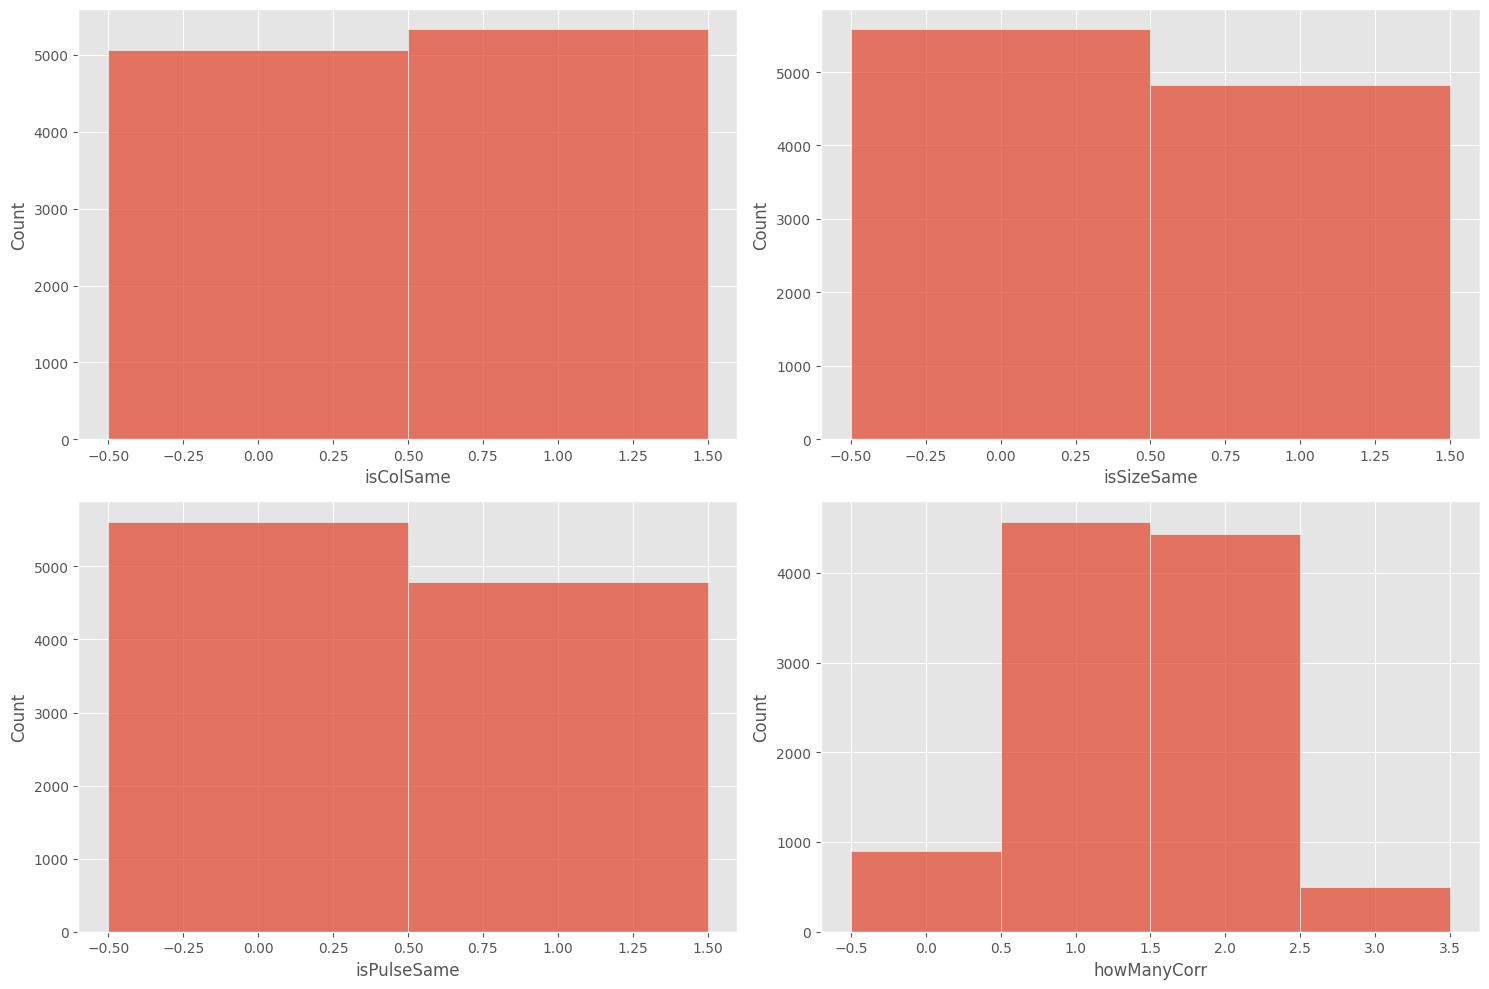

In [15]:
other_cols = [
    'isColSame',
    'isSizeSame',
    'isPulseSame',
    'howManyCorr',
]
fig, axes = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
for i, col in enumerate(other_cols):
    sns.histplot(data=df_comb, x=col, ax=axes[i//2, i%2], discrete=True)
plt.show()

## Analyze continuous variables

In [16]:
df_comb.groupby('corrQuad')[['distToMiddle']].describe()

distToMiddle                                                    \
                count      mean       std       min       25%       50%   
corrQuad                                                                  
A              1402.0  0.094972  0.055219  0.004420  0.048143  0.076526   
B              6842.0  0.124789  0.055454  0.017288  0.083781  0.119801   
C               362.0  0.046510  0.024783  0.008812  0.029319  0.043127   
D              1794.0  0.091952  0.047898  0.014086  0.060839  0.088636   

                              
               75%       max  
corrQuad                      
A         0.128358  0.244290  
B         0.162152  0.287485  
C         0.065177  0.087895  
D         0.122777  0.248793

In [17]:
df_comb['corrected_dist_to_middle'] = np.sqrt((df_comb['x'] - 50)**2 + (df_comb['y'] - 50)**2)
df_comb['min_boundary_distance'] = (df_comb[['x', 'y']] - 50).abs().min(axis=1)
df_comb.head()

,Unnamed: 0,currImg,subj,resp,corrQuad,distToMiddle,meanSD,howManyCorr,isColSame,isSizeSame,isPulseSame,is_correct,x,y,quadrant,calc_is_correct,corrected_dist_to_middle,min_boundary_distance
0,1,1,5,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True,6.454934,1.117196
1,2,1,8,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True,6.454934,1.117196
2,3,1,12,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True,6.454934,1.117196
3,4,1,14,A,B,0.133365,17.982569,2,1,1,0,False,48.882804,56.357519,A,True,6.454934,1.117196
4,5,1,15,B,B,0.133365,17.982569,2,1,1,0,True,48.882804,56.357519,A,False,6.454934,1.117196


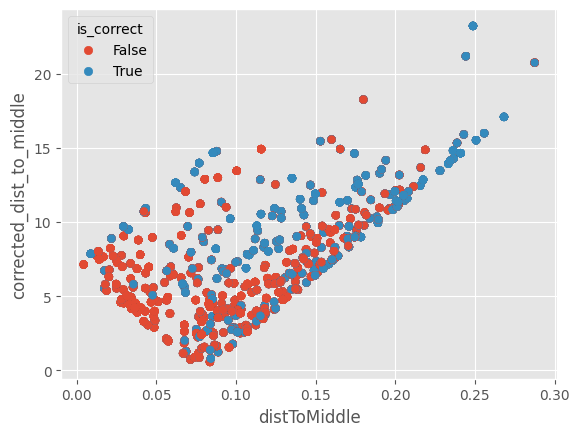

In [18]:
sns.scatterplot(data=df_comb, x='distToMiddle', y='corrected_dist_to_middle', hue='is_correct', linewidth=0)
plt.show()

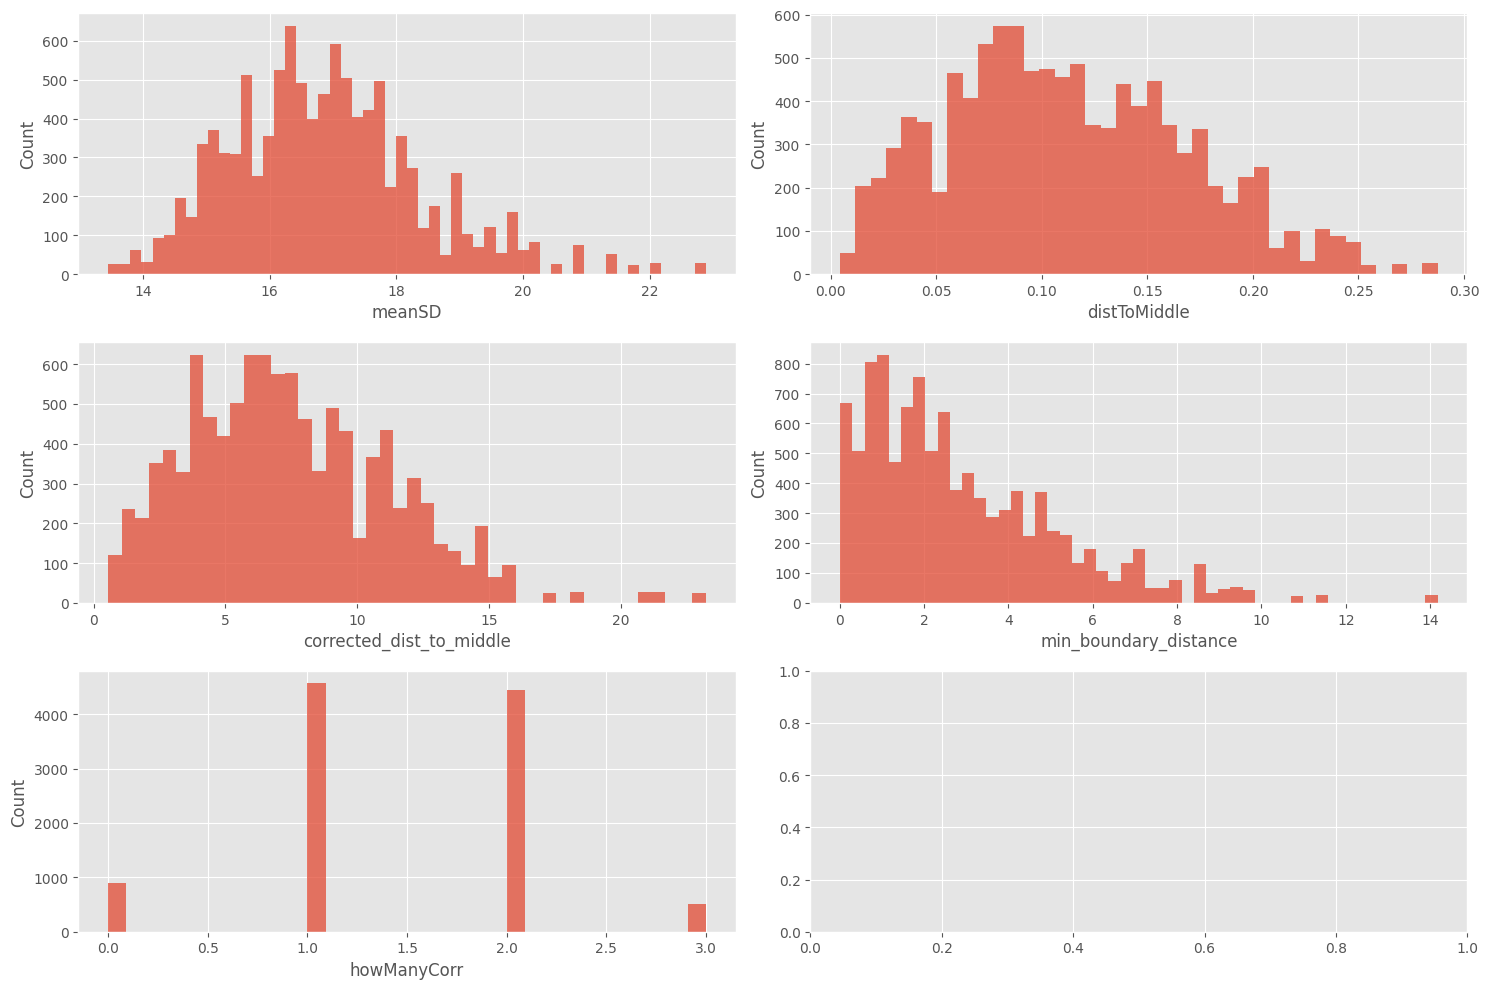

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(15,10), tight_layout=True)
axes = axes.flatten()
cols = ['meanSD', 'distToMiddle', 'corrected_dist_to_middle', 'min_boundary_distance', 'howManyCorr']
for i, col in enumerate(cols):
    sns.histplot(data=df_comb, x=col, linewidth=0, ax=axes[i])
plt.show()

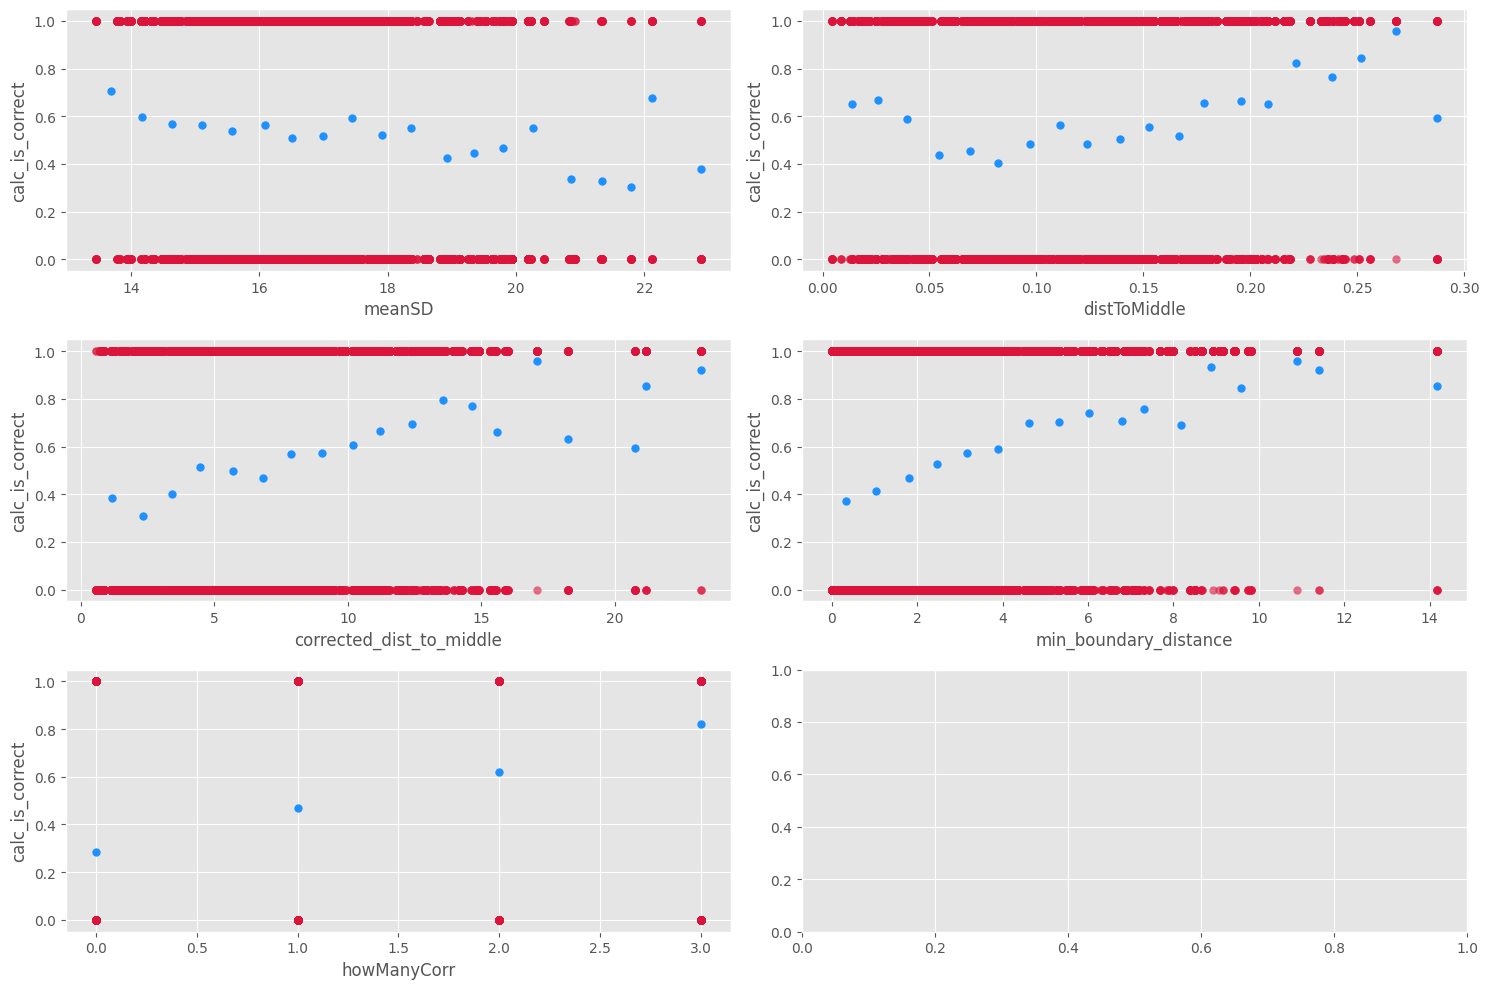

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(15,10), tight_layout=True)
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.scatterplot(data=df_comb, x=col, y='calc_is_correct', linewidth=0, ax=axes[i], alpha=0.6, color='crimson')

    df_comb['cuts'] = pd.cut(df_comb[col], bins=20)
    cut_groups = df_comb.groupby('cuts')[[col, 'calc_is_correct']].mean()
    sns.scatterplot(data=cut_groups, x=col, y='calc_is_correct', linewidth=0, ax=axes[i], color='dodgerblue')
plt.show()